### Name - Kartikeya Singh
### Roll No - 101953023
### Group - 4CO24

# We use Xtreme Gradient Boosting Machine for solving the time series prediction problem of Road sensor dataset

## Declaration and Preprocessing

In [1]:
# Import Section
import random
import math
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read and print the excel file
df = pd.read_excel('DATASET.xlsx')

In [4]:
# Print the dataset
df.head()

,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


In [5]:
# Remove anomolies of sections
clear_idx = 910
lst_to_clear=[clear_idx+i for i in range(9)]
df.fillna(0, inplace=True)
df.drop(lst_to_clear, inplace = True)

In [6]:
# Rename column to section_name
df.columns = df.columns.str.replace('Unnamed: 0', 'Section_name')

In [7]:
# Naming sections 
mul = 10
j = 0
for i in range(100):
  sec_name = df.iloc[j,0]
  df.iloc[j:j + mul, 0] = sec_name
  j += mul
test_frame = df.loc[df['year'] == 10]
df.head()

,Section_name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


# Training and Testing
## Define the Xtreme Gradient Boosting Machine

In [8]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42)

## Extract the test and training dataset for each section

In [9]:
# Extract the training part of input dataset
move = 9
def extract_xtrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, 1:10]

In [10]:
# Extract the training part of output dataset
def extract_ytrain(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_start:row_end, col_start]

In [11]:
# Extract the testing part of input dataset
def extract_xtest(df, row_start):
  row_end = row_start + move
  return df.iloc[row_end, 1:10].to_numpy()

In [12]:
# Extract the output part of ouput dataset
def extract_ytest(df, row_start, col_start):
  row_end = row_start + move
  return df.iloc[row_end, col_start]

In [13]:
# function to calcuate mean square error
def calcuate_lmse(predict_val, test_val):
  pred_diff = predict_val - test_val
  return (pred_diff)**2

In [14]:
# Get the XY Split
column_name = ["Para-"+str(i) for i in range(9,14)]
XY = []
def getXYsplit(df, row_start, row_end):
  XY = []
  XY.append(extract_xtrain(df, row_start, row_end))
  XY.append(extract_ytrain(df, row_start, row_end))
  XY.append(extract_xtest(df,row_start))
  XY.append(extract_ytest(df,row_start,row_end))
  return XY

In [15]:
from collections import defaultdict

In [16]:
# Create a dictionary for storing predicted and true values
pred_values = defaultdict(lambda : [])

In [17]:
target_col = [10,11,12,13,14]
root_mean_square_error = []
total_count = 0
curr_section = 0
total_squared_error = 0
max_val = 1000
for j in target_col:
  local_squared_error = 0
  l_count = 0
  LXY = [0,0,0,0]
  for i in range(0, max_val, 10):
    LXY = getXYsplit(df,i,j)
    x_train, y_train,x_test,y_test = LXY[:4]

    model.fit(x_train, y_train)
    ypred = model.predict(x_test.reshape(1,-1))[0]

    # store the predicted values
    pred_values[column_name[curr_section]].append(ypred)
    
    # store squared difference for RMSE

    # local_squared_error = calcuate_lmse(ypred, y_test) + local_squared_error
    total_squared_error = calcuate_lmse(ypred, y_test) + total_squared_error
    l_count += 1
    total_count += 1

  # root_mean_square_error.append(local_squared_error)
  curr_section += 1
predicted_df = pd.DataFrame.from_dict(pred_values)

In [18]:
# Calculate  RMSE
from sklearn.metrics import r2_score
print(f'R2 score for the model is: {r2_score(test_frame.iloc[:,10],predicted_df.iloc[:,0])}')
total_rmse_by_n = total_squared_error/total_count
final_rmse = total_rmse_by_n**0.5

print(f"The RMSE is {final_rmse}")

R2 score for the model is: 0.8863876513185093
The RMSE is 25.610470773009403


In [19]:
predicted_df

,Para-9,Para-10,Para-11,Para-12,Para-13
0,3.398811e+00,6.049885e+01,5.699891e+01,7.999336,1.918818
1,6.089891e+01,3.019855e+01,9.993413e-01,7.999299,0.792745
2,7.539892e+01,1.074621e-14,1.074621e-14,13.998545,1.412780
3,2.479873e+01,5.698064e+01,6.399891e+01,7.999380,1.887874
4,1.074621e-14,2.617977e+02,3.399949e+01,5.999571,1.768963
...,...,...,...,...,...
95,1.893978e+02,1.916988e+02,9.998878e+00,7.998791,1.554789
96,5.198826e+00,7.109889e+01,2.399929e+01,11.999558,1.075073
97,1.221987e+02,6.769852e+01,1.499837e+01,11.998895,0.981828
98,1.407989e+02,2.927989e+02,1.669982e+02,11.999269,2.120749


# Plot

In [20]:
df

,Section_name,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.520
1,Sec_1,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.620
2,Sec_1,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.680
3,Sec_1,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.780
4,Sec_1,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,Sec_101,6,454.0,931.8,13.6,125.0,13,116,4150,830,15.1,1.8,1.0,15,1.681
1005,Sec_101,7,454.0,703.0,14.5,17.0,13,118,4150,830,24.6,7.9,2.0,15,1.838
1006,Sec_101,8,454.0,1124.1,14.9,45.0,18,117,4200,840,119.0,15.7,2.0,16,1.862
1007,Sec_101,9,454.0,1462.3,13.2,62.0,27,117,4400,720,138.2,30.5,6.0,18,1.883


In [21]:
# Get random rows for plotting
plot_row = 150

random_rows = [random.randint(0,90) for i in range(plot_row)]

## Plot for Para-9

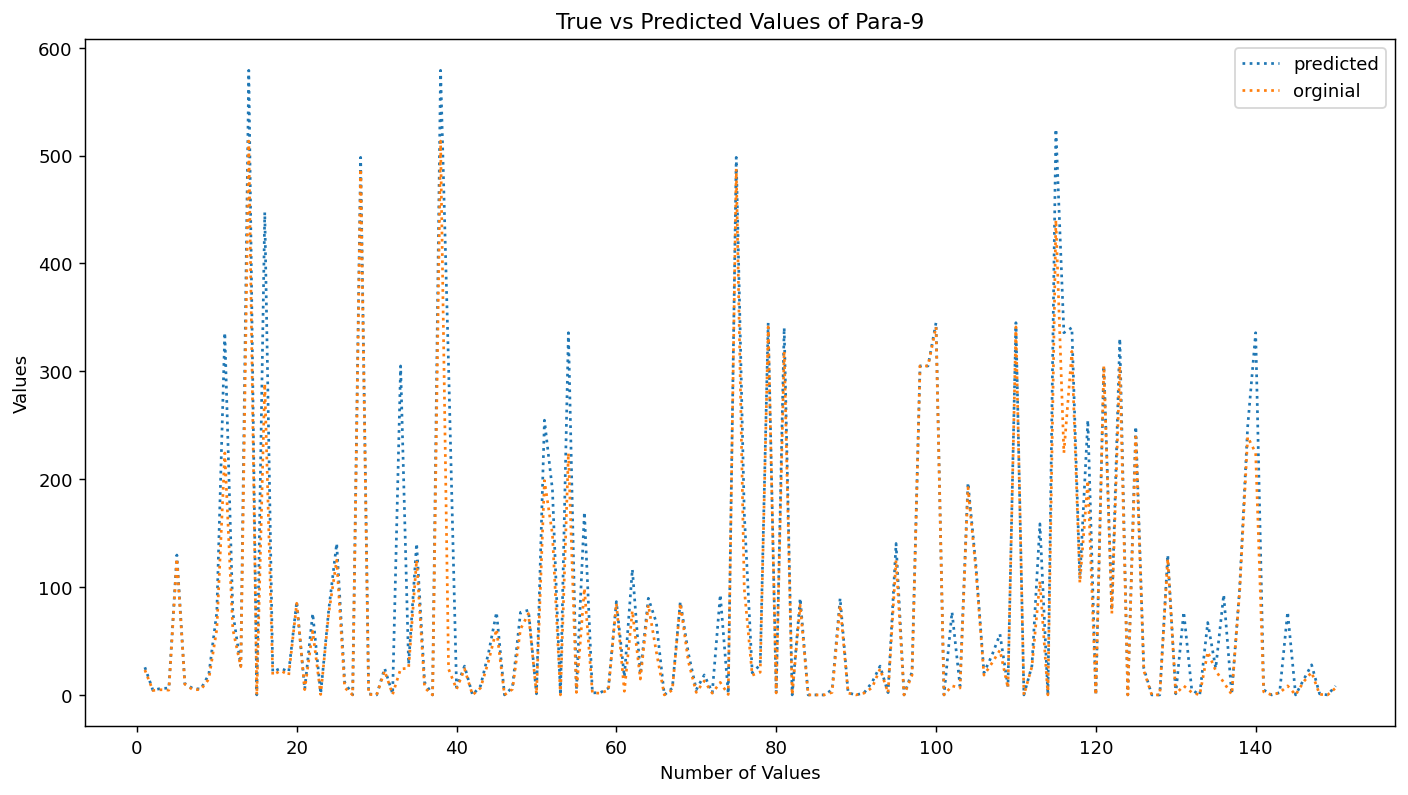

In [22]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,10]
x_value = [i+1 for i in range(len(true_value))]
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-9')
plt.legend(loc = 'upper right')

## Plot for Para-10

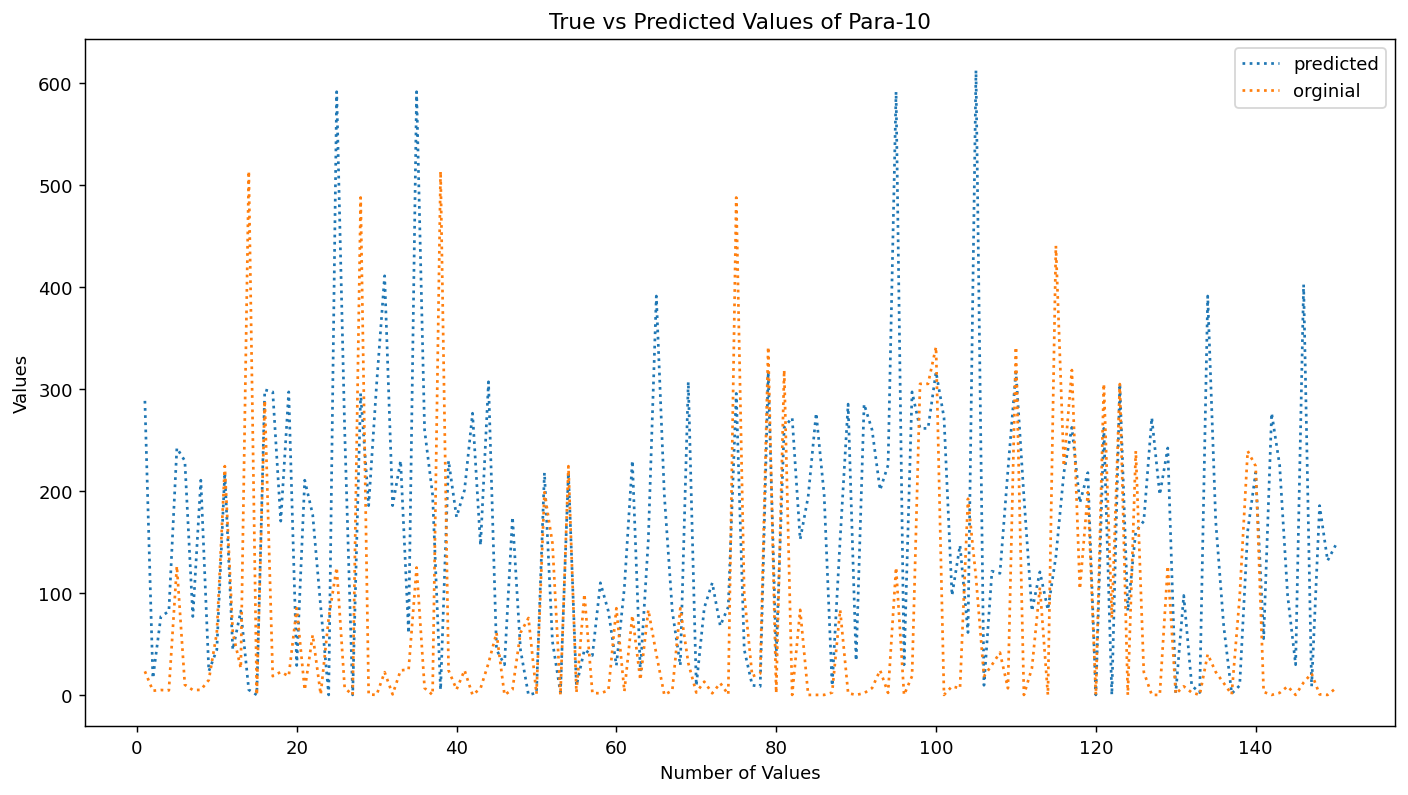

In [23]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,11]
x_value = [i+1 for i in range(len(true_value))]
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-10')
plt.legend(loc = 'upper right')

## Plot for Para-11

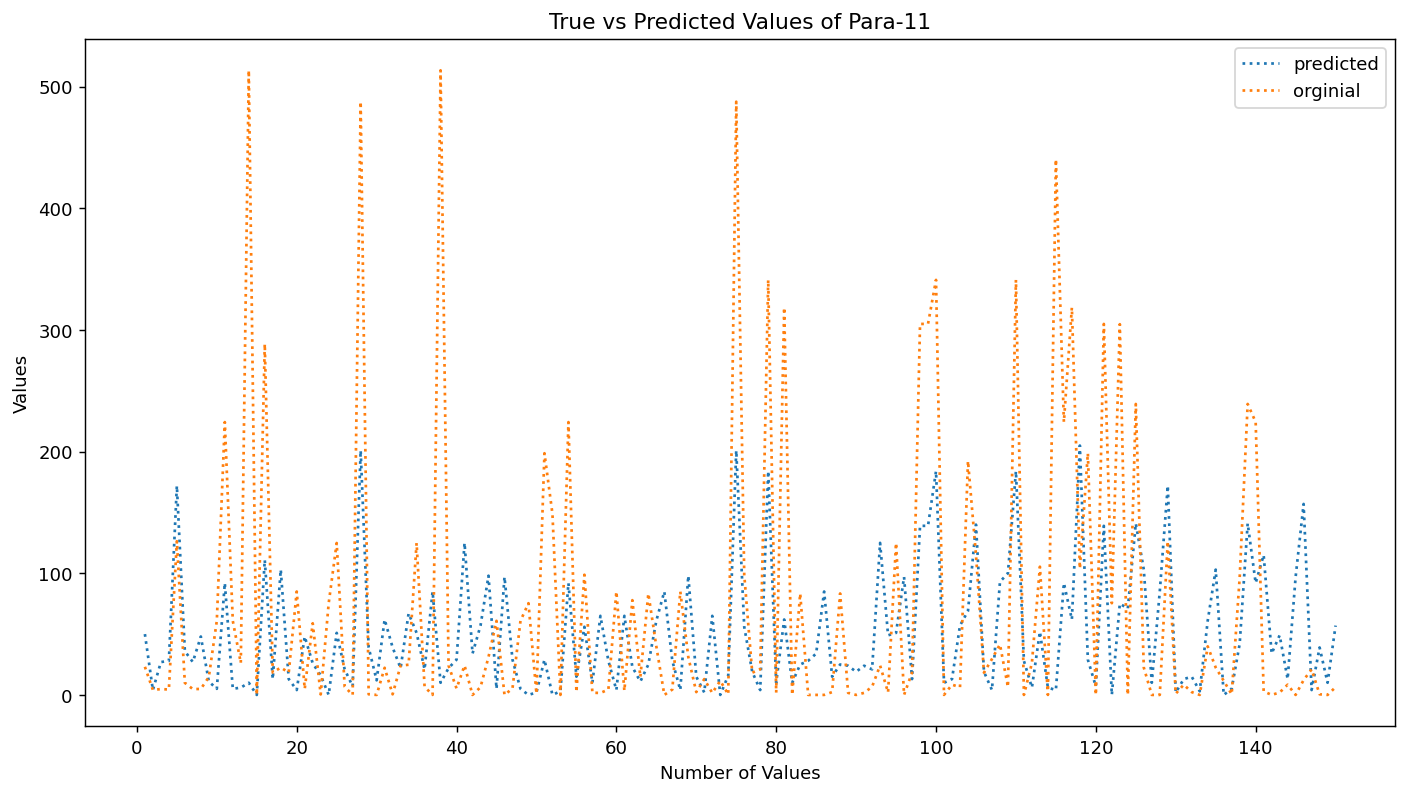

In [24]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,12]
x_value = [i+1 for i in range(len(true_value))]
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-11')
plt.legend(loc = 'upper right')

## Plot for Para-12

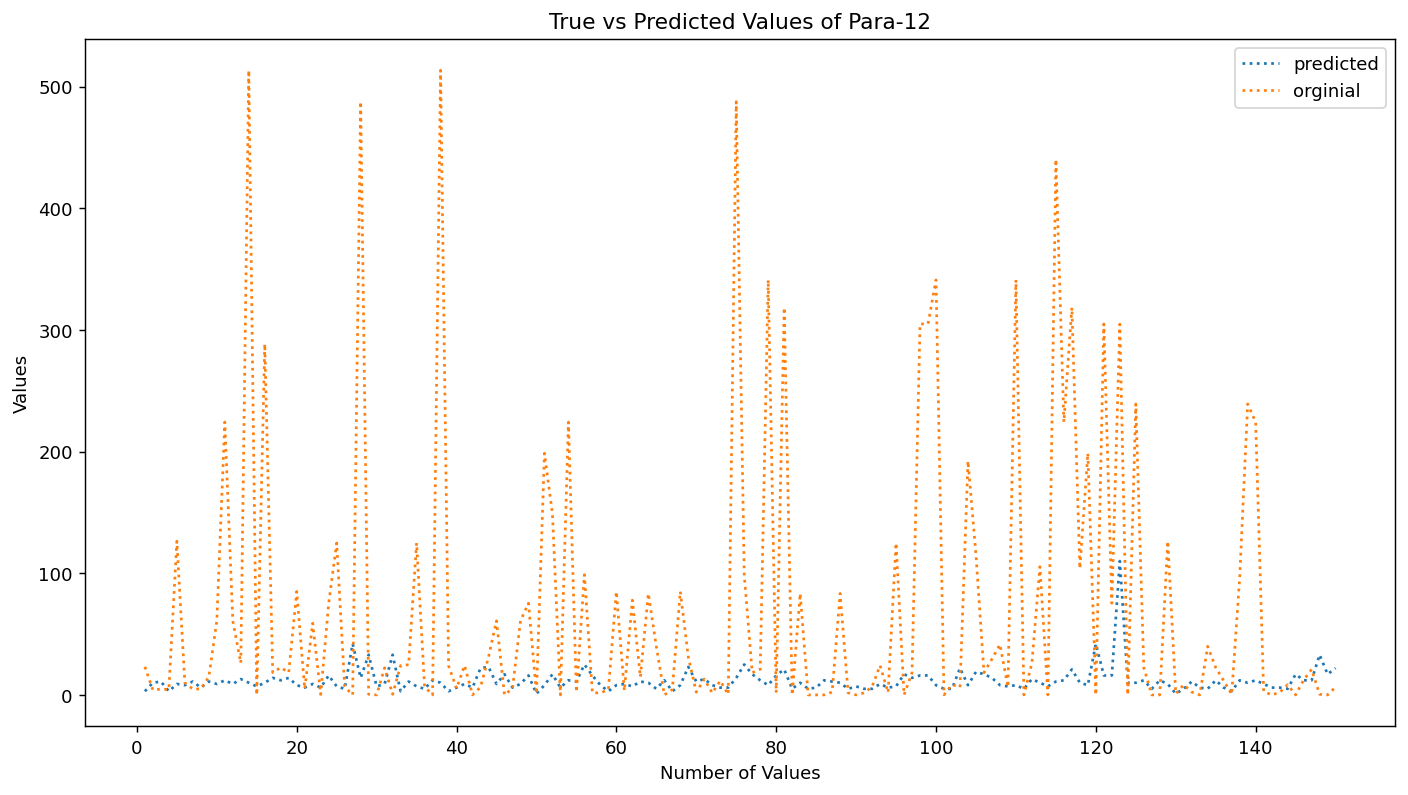

In [25]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,13]
x_value = [i+1 for i in range(len(true_value))]
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-12')
plt.legend(loc = 'upper right')

## Plot for Para-13

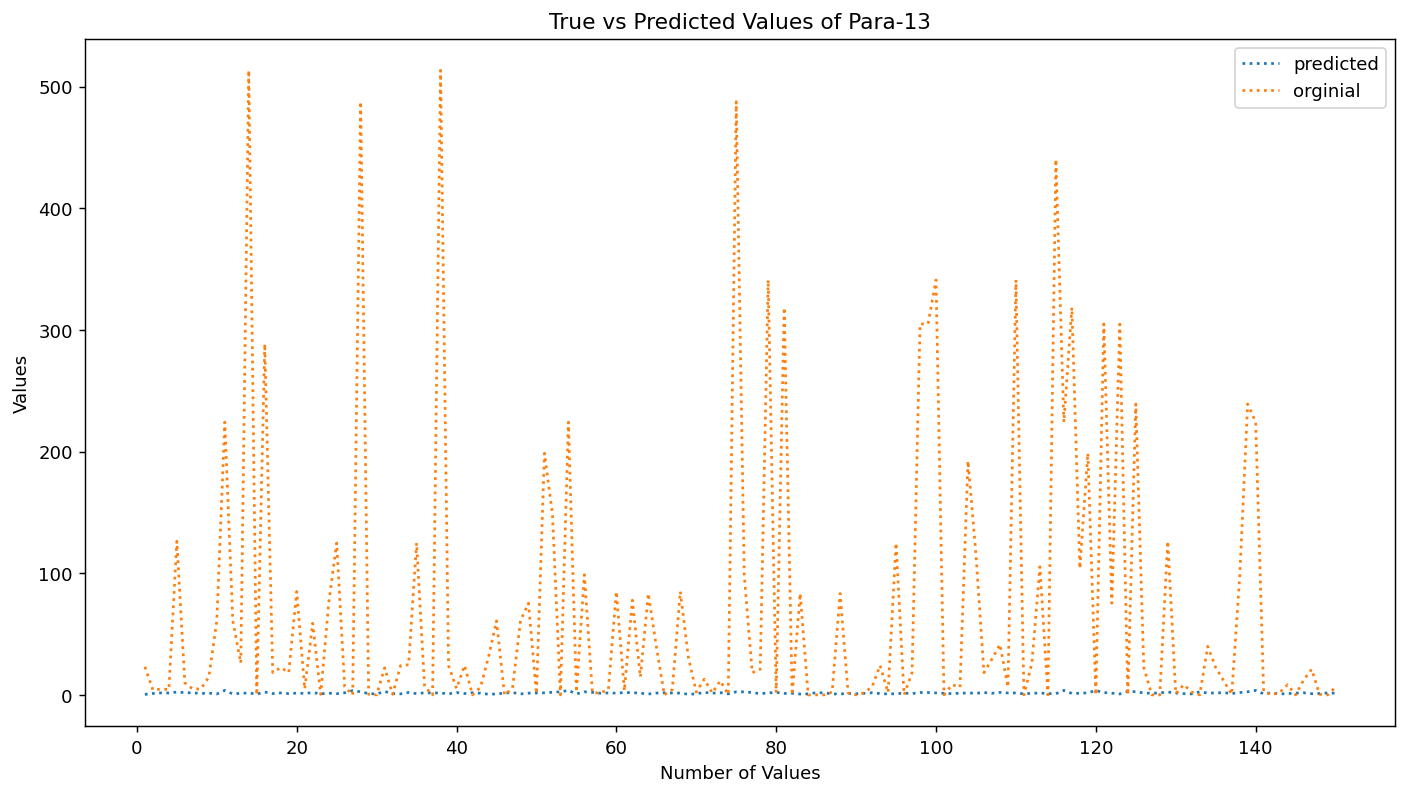

In [26]:
figure(figsize=(13, 7), dpi=130)
true_value = predicted_df.iloc[random_rows, 0]
predicted_value = test_frame.iloc[random_rows,14]
x_value = [i+1 for i in range(len(true_value))]
plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
plt.xlabel('Number of Values')
plt.ylabel('Values')
plt.title('True vs Predicted Values of Para-13')
plt.legend(loc = 'upper right')